## Wine recommendation using Cosine Similarity and TF-IDF analysis outcome

In [36]:
# import libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [34]:
# load the data 
df = pd.read_csv('../winemag-data-130k-v2.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [35]:
df = df[['variety', 'description']]

In [37]:
# drop rows with missing values and duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [38]:
df.shape

(119964, 2)

In [39]:
# how many varieties
varieties = df['variety'].value_counts()[df['variety'].unique()]

In [ ]:
description_by_variety=df.set_index("variety")

In [45]:
new_df=pd.DataFrame(columns=["variety", "description"]) # create a new dataframe to store the description of each variety

In [46]:
cv = CountVectorizer(stop_words='english', ngram_range=(2, 2)) # ngram_range=(2, 2) for bigrams, to get only the most common words
tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True) # smooth_idf=True to avoid division by zero

for wine in varieties.index:
    df = description_by_variety.loc[[wine]] 

    # generating word counts for the words in the description of each variety
    word_count_vector=cv.fit_transform(df['description'])

    # generating tf-idf for the words in the description of each variety
    tfidf_transformer.fit_transform(word_count_vector)

    # top 100 common words (low IDF values) used in the reviews
    df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"])
    df_idf.sort_values(by=['idf_weights'], ascending=True, inplace=True)
    common100 = df_idf.iloc[:100, :]

    # create a dataframe with varieties that have the most common words in their description
    common100 = common100.reset_index()
    common100 = common100['index'].str.cat(sep=', ')
    # using pandas.concat() instead of append() since append() will be deprecated in the future
    new_df = pd.concat([new_df, pd.DataFrame({'variety': wine, 'description': common100}, index=[0])], ignore_index=True)

In [47]:
new_df.head()

,variety,description
0,White Blend,"sauvignon blanc, stone fruit, palate offers, t..."
1,Portuguese Red,"ready drink, black fruits, wood aging, berry f..."
2,Pinot Gris,"pinot gris, fruit flavors, pear fruit, apple p..."
3,Riesling,"dry riesling, lemon lime, stone fruit, fruit f..."
4,Pinot Noir,"pinot noir, black cherry, cherry fruit, fruit ..."


In [48]:
new_df.shape

(707, 2)

In [49]:
tfidf=TfidfVectorizer(stop_words="english", ngram_range=(2,2)) # ngram_range=(2, 2) for bigrams, to get only the most common words
tfidf_matrix=tfidf.fit_transform(new_df['description'])
tfidf_matrix.shape 

(707, 63183)

In [50]:
# find cosine similarity
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [53]:
new_df.reset_index(inplace=True)

In [56]:
# take varities as index and number of varieties as values
indices = pd.Series(new_df.index, index=new_df['variety'])

In [57]:
indices

variety
White Blend                   0
Portuguese Red                1
Pinot Gris                    2
Riesling                      3
Pinot Noir                    4
                           ... 
Pignolo                     702
Caprettone                  703
Ondenc                      704
Athiri                      705
Bobal-Cabernet Sauvignon    706
Length: 707, dtype: int64

In [60]:
# Make a function that takes in the grape variety as an input and produces a DataFrame of three similar varieties and key words of their reviews
def recommendations(variety, cosine_similarities=cosine_similarities):
    similarity_scores = list(enumerate(cosine_similarities[indices[variety]]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:4]
    variety_indices = [i[0] for i in similarity_scores]
    
    # create the output dataframe
    output = pd.DataFrame(columns=['Similar wines found', 'Top 5 common words from reviews'])
    for i in variety_indices:
        variety = new_df.iloc[i]['variety']
        description = new_df.iloc[i]['description']

        if variety in varieties[varieties > 1].index: # I want to display the varieties that have more than 1 review for recommendation
            split_description = description.split(', ')
            top5 = split_description[:5]
            top5 = ', '.join(top5)
        else:
            top5 = 'N/A'
        

        output = pd.concat([output, pd.DataFrame({'Similar wines found': variety, 'Top 5 common words from reviews': top5}, index=[0])], ignore_index=True)

    output.set_index('Similar wines found', inplace=True)

    pd.set_option('max_colwidth', 500)

    return output

In [61]:
recommendations('Pinot Noir')

,Top 5 common words from reviews
Similar wines found,
Merlot,"black cherry, fruit flavors, red fruit, medium bodied, cherry flavors"
Grenache,"fruit flavors, red fruit, white pepper, red cherry, cherry fruit"
Cabernet Franc,"cabernet franc, cab franc, black cherry, fruit flavors, red cherry"


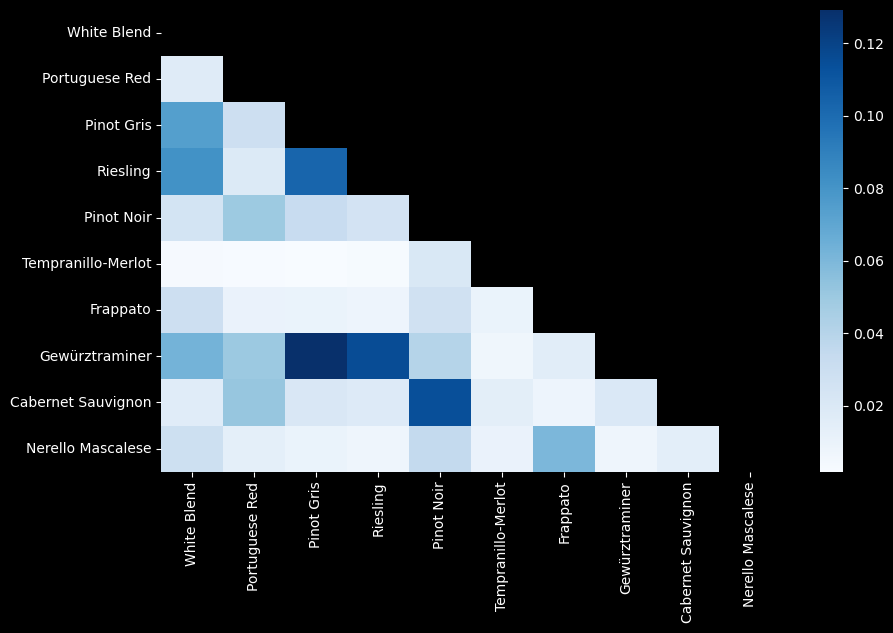

In [87]:
# get cosine similarity heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

mask1 = np.triu(np.ones_like(cosine_similarities[:10, :10], dtype=bool)) # mask to hide the upper triangle of the heatmap

# set size 
plt.figure(figsize=(10, 6))

# dark background
plt.style.use('dark_background')

# show only top half of the heatmap
sns.heatmap(cosine_similarities[:10, :10], cmap='Blues', xticklabels=new_df['variety'][:10], yticklabels=new_df['variety'][:10], mask=mask1)

plt.show()